# Accelerating Python

Main reference:
- [*Numerical Python*](https://link.springer.com/book/10.1007/978-1-4842-4246-9), Robert Johansson, Chapter 19: *Code Optimization*

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numba

[`Numba`](https://numba.pydata.org)
=================================

In [4]:
def py_sum(data: list):
    """Pythonic-function: sum
    """
    s = 0
    for d in data:
        s += d
    return s

In [5]:
repeat = 50000
data = np.random.randn(repeat)

In [6]:
# profile to output
# following https://stackoverflow.com/questions/17310752/can-you-capture-the-output-of-ipythons-magic-methods-timeit
t_py = %timeit -o py_sum(data)

9.14 ms ± 179 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
dir(t_py)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_precision',
 '_repr_pretty_',
 'all_runs',
 'average',
 'best',
 'compile_time',
 'loops',
 'repeat',
 'stdev',
 'timings',
 'worst']

In [8]:
t_py.average

0.009137381247138754

In [9]:
t_np = %timeit -o np.sum(data)

16.9 µs ± 90.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
def times(a: float, b: float):
    """return the ratio of average runtime of a and b"""
    t = a.average / b.average
    print("ratio of average runtime: ", round(t))

In [11]:
times(t_py, t_np)

ratio of average runtime:  542


Check if py_sum and np.sum return the **equal** results *within given tolerence*

In [12]:
tolerence = 1e-10
assert abs(py_sum(data) - np.sum(data)) < tolerence

`numba.jit` Decorator
---------------------
See [PEP 318](https://www.python.org/dev/peps/pep-0318/) -- Decorators for Functions and Methods for details about the "decorator".

In [13]:
@numba.jit
def jit_sum(data):
    s = 0
    for d in data:
        s += d
    return s

In [14]:
t_jit = %timeit -o jit_sum(data)

58.3 µs ± 170 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
times(t_py, t_jit)

ratio of average runtime:  157


Decorate an defined function
----------------------------

In [16]:
jit_sum2 = numba.jit()(py_sum)

In [17]:
t_jit2 = %timeit -o jit_sum2(data)

59.1 µs ± 981 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
t_jit2.average

5.911421588568503e-05

Check equality within the given tolerence

In [19]:
assert abs(py_sum(data) - jit_sum(data)) < tolerence

Julia fractal
---------
The [*Julia set*](https://brilliant.org/wiki/fractals/) is defined as the set of all complex numbers, $z$, which arebounded under repeated iteration of the complex quadratic polynomial
$$
z_{n+1} = z_n^2 + c
$$
for a constant complex number $c$.

In [20]:
def py_julia_fractal(z_re, z_im, j):
    """Pythonic function of Julia fractal"""
    c = -0.05 + 0.68j
    for m in range(len(z_re)):
        for n in range(len(z_im)):
            z = z_re[m] + 1j * z_im[n]
            for t in range(256):
                z = z ** 2 + c
                if np.abs(z) > 2.0:
                    j[m, n] = t
                    break

In [21]:
N = 1024
z_real = np.linspace(-1.5, 1.5, N)
z_imag = np.linspace(-1.5, 1.5, N)

In [22]:
j = np.zeros((N, N), np.int64)
t_py_julia = %timeit -n1 -r1 -o py_julia_fractal(z_real, z_imag, j)

45.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [23]:
jit_julia_fractal = numba.jit(nopython=True)(py_julia_fractal)

In [24]:
j = np.zeros((N, N), np.int64)
t_jit_julia = %timeit -o jit_julia_fractal(z_real, z_imag, j)

224 ms ± 971 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
times(t_py_julia, t_jit_julia)

ratio of average runtime:  204


`numba.jit(nopython=True)` is equivalent to `numba.njit()`

In [26]:
njit_julia_fractal = numba.njit()(py_julia_fractal)

In [27]:
j = np.zeros((N, N), np.int64)
t_njit_julia = %timeit -o jit_julia_fractal(z_real, z_imag, j)

227 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
times(t_jit_julia, t_njit_julia)

ratio of average runtime:  1


Text(0, 0.5, '$\\mathrm{Im}(z)$')

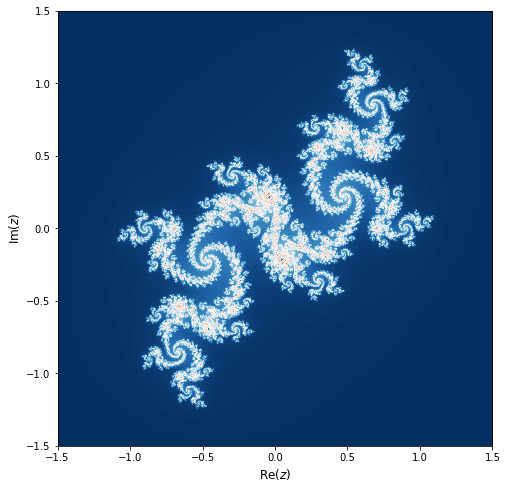

In [29]:
fig, ax =plt.subplots(figsize=(8, 8))
ax.imshow(j, cmap=plt.cm.RdBu_r, extent=[-1.5, 1.5, -1.5, 1.5])
ax.set_xlabel("$\mathrm{Re}(z)$", fontsize=12)
ax.set_ylabel("$\mathrm{Im}(z)$", fontsize=12)

Heaviside step function:
\begin{equation}
\Theta(x) =
\begin{cases}
0, \quad & x < 0 \\
1/2, & x = 0 \\
1, & x > 0
\end{cases}
\end{equation}

`numba.vectorize`
-----------------

In [30]:
def py_Heaviside(x: float):
    """Heaviside step function"""
    if x == 0.0:
        return 0.5
    elif x < 0.0:
        return 0.0
    else:
        return 1.0

In [31]:
x = np.linspace(-2, 2, 50001)
t_py_H = %timeit -o [py_Heaviside(xx) for xx in x]

15.6 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
np_vec_Heaviside = np.vectorize(py_Heaviside)
t_np_H = %timeit -o np_vec_Heaviside(x)

6.69 ms ± 30.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
def np_Heaviside(x):
    """x: NumPy array"""
    return (x > 0.0) + (x == 0.0) / 2.0

In [34]:
t_npa_H = %timeit -o np_Heaviside(x)

176 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [35]:
times(t_np_H, t_npa_H)

ratio of average runtime:  38


In [36]:
@numba.vectorize([numba.float32(numba.float32),
                  numba.float64(numba.float64)])
def jit_Heaviside(x):
    if x == 0.0:
        return 0.5
    if x < 0:
        return 0.0
    else:
        return 1.0

In [37]:
t_jit_H = %timeit -o jit_Heaviside(x)

17.6 µs ± 22 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [38]:
times(t_np_H, t_jit_H)

ratio of average runtime:  380


In [39]:
jit_Heaviside(x[24990:25010])

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. ])

Fastmath
--------
Pease efer to https://numba.pydata.org/numba-doc/latest/user/performance-tips.html for other performance tips.

In [40]:
njit_f_H = numba.njit(fastmath=True)(np_Heaviside)

In [41]:
t_njit_f_H = %timeit -o njit_f_H(x)

24.3 µs ± 203 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


[`Cython`](https://cython.org/)
=============================

In [42]:
%load_ext Cython

In [43]:
%%cython

def cy_sum(data):
    s = 0.0
    for d in data:
        s += d
    return s

In [44]:
t_cy = %timeit -o cy_sum(data)

8 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
times(t_py, t_cy)

ratio of average runtime:  1


In [46]:
%%cython
cimport numpy
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_sum2(numpy.ndarray[numpy.float64_t, ndim=1] data):
    cdef numpy.float64_t s = 0.0
    cdef int n, N = len(data)
    for n in range(N):
        s += data[n]
    return s

In [47]:
t_cy2 = %timeit -o cy_sum2(data)

58.5 µs ± 260 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [48]:
times(t_py, t_cy2)

ratio of average runtime:  156


Summary
=======

- `Numba` 几乎不必修改原 `Python` 代码，即可实现对特定 `Python` 函数的优化，特别是与 `for` 循环和 `NumPy` 相关的优化
- `Cython` 在几乎不修改原 `Python` 代码的基础上，优化幅度较小；为得到较好的优化，需要对原 `Python` 代码进行较大的修改